# Calculating kernel density estimations for LAPS sensitivity model run

Code from here: https://towardsdatascience.com/simple-example-of-2d-density-plots-in-python-83b83b934f67

This also seems like a good page to read and perhaps use this method instead: https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html



In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from itertools import chain   # This is to turn an array into a list 

## Open the trajectory output file
This is the output file from a Parcels run and should be a netcdf with trajectory, time, lat, lon, etc.

Then limit the data to the PLD you want. To do this you just select all particles with the age that equals your desired PLD. 

In [36]:
# Open dataset
ds = xr.open_dataset('LAPS_sensitivity_n1_pld180_0m_Kh0_nday545_daily_07012012_withBounce.nc')

In [71]:
#Select only the particles of age=PLD
pld = 90
dsSub = ds.where(ds.age == pld*86400, drop=True)
dsSub

<xarray.Dataset>
Dimensions:      (traj: 149630, obs: 1)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory   (traj, obs) float64 820.0 821.0 822.0 ... 1.509e+05 1.509e+05
    time         (traj, obs) datetime64[ns] 2012-09-29 2012-09-29 ... 2013-09-29
    lat          (traj, obs) float32 17.81 17.81 17.81 ... 19.46 19.46 19.46
    lon          (traj, obs) float32 145.4 145.4 145.4 ... 183.4 183.4 183.4
    z            (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dU           (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dV           (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    d2s          (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    age          (traj, obs) float32 7.776e+06 7.776e+06 ... 7.776e+06 7.776e+06
    releaseSite  (traj, obs) float32 1.0 1.0 1.0 1.0 1.0 ... 11.0 11.0 11.0 11.0
    distance     (traj, obs) float32 1.306e+06 1.306e+06 ... 1.346e+06 1.346e+06
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev67+g491d9665
    parcels_mesh:           spherical

Then make x and y objects with the lon and lat data. I converted them to lists because I couldn't get it to work with arrays, but I'm sure there is a much more elegant way to do this! 

In [72]:
x = dsSub.lon.values
y = dsSub.lat.values

x = list(chain.from_iterable(x))
y = list(chain.from_iterable(y))

## Calculate the density kernel
Here we are doing two different versions: 
1. The first is to to just look at the data using a 2D histrogram. 
2. The second method uses a Gaussian kernel density calculation. 

### 2D Histogram

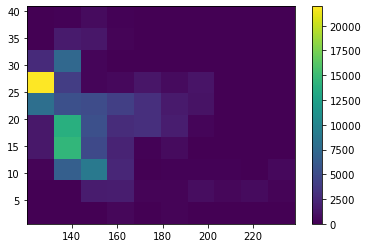

In [73]:
h =plt.hist2d(x, y)
plt.colorbar(h[3])

Make sure everything looks somewhat as you expect. 

### Gaussian KDE
Moving on the the Gaussian Kernel Density Estimation (KDE). First we define the limits and resolution of the grid we want to use. Here I used just the min and max lat and lon with some buffer just by looking at a map where the data points are located. You can do this also by calulating the min and max of the data itself and adding a buffer. I chose the manual version becuase it's tidier, but if you are running a bunch of different regions it's worth automating it with the min and max calculations. 

In [74]:
# Define the borders
xmin = 120
xmax = 240
ymin = 0
ymax = 50
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:1, ymin:ymax:1]

120 240 0 50


We will fit a gaussian kernel using the scipy’s *gaussian_kde* method:

In [75]:
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

`f` here is your density kernel values. These are what you can use for your regressions

Plotting the kernel with annotated contours

Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

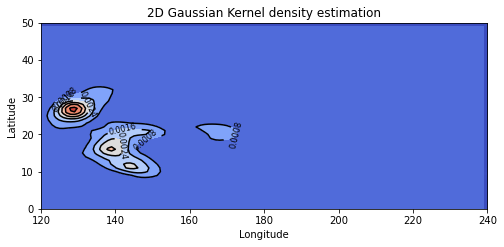

In [76]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=8)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('2D Gaussian Kernel density estimation')

## Save the KDE
Save the kernel density estimation as a csv file. This can be read into R or analyzed further in Python. 

In [77]:
np.savetxt('LAPS_90day_KDE.csv', f, delimiter=',')